In [63]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

import PyCodesDataProcessingBase.DataProceesingBase_GetBusNet as gbn
import PyCodesDataProcessingBase.DataProceesingBase_GetTrainNet as gtn
import PyCodesDataProcessingBase.DataProceesingBase_GetTransitVol as gtv
import PyCodesDataProcessingBase.DataProcessingBase_GetZonePop as gzp

In [64]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.color'] = '#6495ED'
matplotlib.rcParams['lines.markeredgecolor'] = 'black'
matplotlib.rcParams['lines.markeredgewidth'] = 0
matplotlib.rcParams['lines.markerfacecolor'] = 'red'
matplotlib.rcParams['lines.markersize'] = 2

In [74]:
import importlib
# importlib.reload()
importlib.reload(gbn)
importlib.reload(gtn)
importlib.reload(gzp)
importlib.reload(gtv)

<module 'PyCodesDataProcessingBase.DataProceesingBase_GetTransitVol' from 'C:\\zhouweifile\\Transportation Data\\Singapore Geodatabase\\PyCodesDataProcessingBase\\DataProceesingBase_GetTransitVol.py'>

In [75]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [67]:
# Current Working Directory
os.chdir(r'C:\zhouweifile\Transportation Data\Singapore Geodatabase')
#
ROOT_PATH = r'C:\zhouweifile\Transportation Data\Singapore Geodatabase'

# 1. Bus information

The process of construct bus (transit) network

1. bus stop location geographical information

    There are two source:

    1. from datamall static datasets: 
    
        - **file type:** `shapefile`
        - **CRS:** EPSG:3414
        - **function:** `gbn.ReadBusStopLocShp()
            - **return:** `geopandas.GeoDataFrame`

    2. from datamall dynamic datasets (API): 
    
        - **file type:** `csv` 
        - **CRS:** GPS (EPGS:4326):
        - **function:** `gbn.ReadBusStopLocCsv()`: 
            - **return:** `geopandas.GeoDataFrame`
        
     3. combine the two source data
     
         - `gbn.BusStopLocUpdate(data1, data2)`
             - both `data1` and `data2` are `geopandas.GeoDataFrame`
             - columns: `['BusStopCode', 'Description', 'geometry']`



2. bus route list

    collected from datamall dynamic datasets (API). The `StopSequence` column can be used to infer the bus line.
    
    - **function:** `gbn.ReadBusRouteCsv()`
        - **return:** `pandas.DataFrame`


3. bus network

    According to bus stop and bus route to construct the bus network (**directed graph** `networkx.DiGraph()`)
    - the stop from 'route' table if not exist in `stop` table will be deleted.
    - the stop from 'stop' table if not exist in `route` table will also be deleted.
    - **function:** `gbn.BusStopRoute2Net(stop, route, multiedge=False)`
        - **multiedge**: `bool`
        - **return:** `networkx.DiGraph()` or `networkx.MultiDiGraph()`
        - `networkx.DiGraph()`
        - `networkx.MultiDiGraph()`


4. bus line

    Construct bus line shapefile (line layer), each line consists of a sequence of bus stop 
    - **function:** `gbn.Route2LineShp(bus_stop, bus_route)`

5. `Gephi`: stop (node) list, route (edge) list

    from bus network (`net`:`networkx.DiGraph()`) construct the stop (node) list and route (edge) list input into *Gephi*
    
    - **function:** `gbn.BusNet2NodeEgesPd(bus_net)`
        - **return:** `node_pd` and `edge_pd` (`pandas.DataFrame`)
    

## 1.1. Get Bus Stop Location

In [61]:
def BusStopLoc():
    
    # bus location from the shapefile
    path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 
        'Stop Location', 'Bus Stop Location (from datamall Static Datasets)',
        'BusStopLocation_Jan2022',  # 'BusStopLocation_Aug2021',
        'BusStop.shp'
    )
    stop_loc = gbn.ReadBusStopLocShp(path)  
    
    # bus location from the csv 
    path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 
        'Stop Location', 'Bus Stop Location (from datamall API)',
        'bus_stops_2021-12-21.csv'
    )
    stop_loc1 = gbn.ReadBusStopLocCsv(path)   
    # print(stop_loc.shape, stop_loc1.shape)
    
    # merge, drop depulicate
    stop_loc = gbn.BusStopLocUpdate(stop_loc, stop_loc1)
    
    return stop_loc
# ======================================================================


bus_stop = BusStopLoc()
display(bus_stop.head(5))

UNION_CRS = bus_stop.crs

# # save file
# bus_stop.to_file('GeoDatabase/shapefiles/bus_stop_loc/bus_stop_loc_20220127.shp')

,BusStopCode,Description,geometry
0,01012,HOTEL GRAND PACIFIC,POINT (30140.804 31031.951)
1,01013,ST JOSEPH'S CH,POINT (30218.752 31126.487)
2,01019,BRAS BASAH CPLX,POINT (30187.770 31034.554)
3,01029,OPP NATL LIB,POINT (30345.826 31007.645)
4,01039,BUGIS CUBE,POINT (30471.076 31175.633)


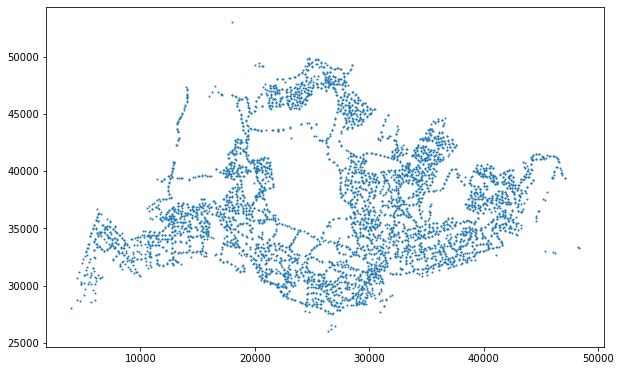

In [52]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = bus_stop.plot(markersize=1, ax=ax1)

## 1.2. Construct Bus Network

### 1.2.1. Get Bus Route

In [56]:
# get bus route list csv file
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Route',
    'Bus Route (from datamall API)',
    'bus_routes_2021-12-21',
    'bus_routes_2021-12-21.csv'
)

bus_route = gbn.ReadBusRouteCsv(path)  
display(bus_route.head(5))

# bus_route1 = bus_route.merge(right=bus_stop, on='BusStopCode', how='inner')
# display(bus_route1.shape, bus_route1.head(5))

,ServiceNo,Operator,Direction,StopSequence,BusStopCode,Distance
0,105,SBST,1,51,28659,24.1
1,105,SBST,1,52,28649,24.8
2,105,SBST,1,53,28639,25.1
3,105,SBST,1,54,28319,25.5
4,105,SBST,1,55,28449,25.8


### 1.2.2. Transform Bus Route to Network

In [57]:
bus_net = gbn.BusStopRoute2Net(bus_stop, bus_route)
bus_net = gbn.NetProcessing(bus_net)
print(len(bus_net.nodes), len(bus_net.edges))

bus_mnet = gbn.BusStopRoute2Net(bus_stop, bus_route, multiedge=True)
print(len(bus_mnet.nodes), len(bus_mnet.edges), bus_route.shape)

5047 7423
5047 25003 (25779, 6)


### 1.2.3. Construct Bus Line (shapefile)

In [58]:
# bus route to shapefile
bus_line_shp = gbn.Route2LineShp(bus_stop, bus_route)

# # save file
# bus_line_shp.to_file('GeoDatabase/shapefiles/bus_line/bus_line_20220127.shp')

C:\Users\e0751551\.conda\envs\py37geo\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """


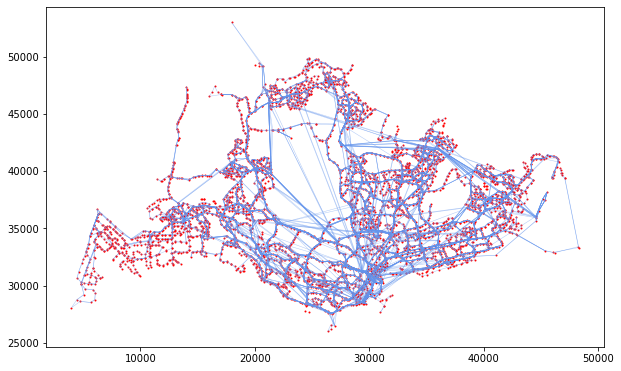

In [59]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = bus_route_shp.plot(lw=0.5, alpha=0.5, ax=ax1)
ax1 = bus_stop.plot(color='red', markersize=1, ax=ax1)

### 1.2.4. Construct Node List and Edge List for *Gephi*

In [12]:
# bus network to node list and edge list, which are input to Gephi
node_pd, edge_pd = gbn.BusNet2NodeEgesPd(bus_net)
print(node_pd.shape, node_pd.head(5))
print(edge_pd.shape, edge_pd.head(5))

# # save file
# path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Gephi - BusNeworks')
# node_pd.to_csv(os.path.join(path, 'bus_network_node_list_20220127.csv'), index=False)
# edge_pd.to_csv(os.path.join(path, 'bus_network_edge_list_20220127.csv'), index=False)

(5047, 5)     Id       lat        lng    serv_num                      serv_li                     
0  28659  35182.395  18468.436     9                  105,188,NR5,333,502,52,657,990,188R
1  28649  35691.350  18278.082    11           41,188,188R,183,333,502,990,657,NR5,105,52
2  28639  35843.396  18063.435    11           990,657,52,502,188,333,188R,183,105,41,NR5
3  28319  35635.008  17804.038     7                             98M,98,52,41,183,176,105
4  28449  35403.314  17580.947    13     98M,105,160,98,52,990,506,49,176,41,334,160M,183
(7423, 5)   Source Target  dist serv_num                   serv_li                  
0  28659  28649   0.7     9            502,657,333,NR5,990,188R,105,52,188
1  28649  28639   0.3    11     502,183,657,333,NR5,990,188R,41,105,52,188
2  28639  28319   0.4     4                                  41,105,52,183
3  28639  28621   0.2     3                                   188R,990,188
4  28639  28321   0.4     4                                502,NR

## 1.3. Bus Stop Value

,IN_WD_0,IN_WD_1,IN_WD_10,IN_WD_11,IN_WD_12,...,IN_WD_total,IN_WE_total,OUT_WD_total,OUT_WE_total,BusStopCode
0,250.0,NaN,539.0,727.0,780.0,...,17087.0,6000.0,18822.0,6495.0,01012
1,43.0,NaN,272.0,340.0,460.0,...,11951.0,4084.0,6541.0,2194.0,01013
2,23.0,NaN,483.0,525.0,608.0,...,8465.0,2634.0,14607.0,4929.0,01019
3,83.0,NaN,637.0,828.0,1146.0,...,18195.0,6152.0,13635.0,4745.0,01029
4,306.0,NaN,813.0,1035.0,1362.0,...,27041.0,11607.0,27365.0,11473.0,01039


NameError: name 'bus_stop_loc' is not defined

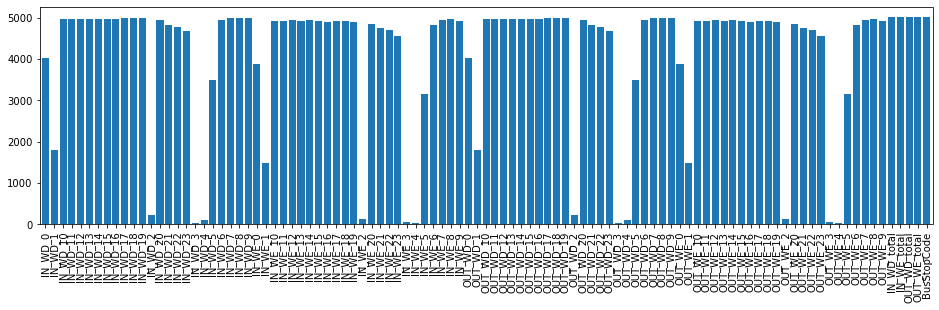

In [13]:
VOL_DATE = '202112'
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Volume', 
    'transport_node_bus_{0}'.format(VOL_DATE[:4]),
    'transport_node_bus_{0}.csv'.format(VOL_DATE)
)

bus_stop_vol = gtv.GetStopVol(path)
display(bus_stop_vol.head())
# explore the nan of bus_stop_vol
bus_stop_vol.notna().sum().plot(kind='bar', figsize=(16, 4), width=0.8)

bus_stop_vol = gtv.MergeStopVolLoc(bus_stop_vol, bus_stop_loc, merge_how='outer')
bus_stop_vol = gpd.GeoDataFrame(bus_stop_vol)

display(bus_stop_vol.head())
print(type(bus_stop_vol), bus_stop_vol.shape)

In [ ]:
# bus_stop_vol.to_file('GeoDatabase/shapefiles/bus_stop_vol/bus_stop_vol_{0}.shp'.format(vol_date))

## 1.4. Bus Stop OD Passenger Trip

In [ ]:
# data: year mouth
VOL_DATE = '202112'

path = os.path.join(ROOT_PATH, 'Public-Trainsit-Bus', 'Volume', 
    'origin_destination_bus_{0}'.format(VOL_DATE[:4]),
    'origin_destination_bus_{0}.csv'.format(VOL_DATE)
)

odtrip = gtv.GetODTrip(path)

display(odtrip.head(10), odtrip.shape)
# odtrip.info()
# allday (312326, 3)

### 1.4.2. Add OD Trip With Stop Location Info

In [ ]:
odtrip_shp =  gtv.ODTrip2Shp(odtrip, bus_stop_loc)

# save to file
# odtrip_shp.to_file('GeoDatabase/shapefiles/bus_stop_vol_OD/bus_OD_{0}.shp'.format(VOL_DATE))

# 2. Train information

The process of construct bus network

1. bus stop location geographical information

    There are two source:

    1. from datamall static datasets: 
    
        - **file type:** `shapefile`
        - **CRS:** EPSG:3414
        - **function:** `gbn.ReadBusStopLocShp()
            - **return:** `geopandas.GeoDataFrame`

    2. from datamall dynamic datasets (API): 
    
        - **file type:** `csv` 
        - **CRS:** GPS (EPGS:4326):
        - **function:** `gbn.ReadBusStopLocCsv()`: 
            - **return:** `geopandas.GeoDataFrame`
        
     3. combine the two source data
     
         - `gbn.BusStopLocUpdate(data1, data2)`
             - both `data1` and `data2` are `geopandas.GeoDataFrame`
             - columns: `['BusStopCode', 'Description', 'geometry']`



2. bus route list

    collected from datamall dynamic datasets (API). The `StopSequence` column can be used to infer the bus line.
    
    - **function:** `gbn.ReadBusRouteCsv()`
        - **return:** `pandas.DataFrame`


3. bus network

    According to bus stop and bus route to construct the bus network (**directed graph** `networkx.DiGraph()`)
    - the stop from 'route' table if not exist in `stop` table will be deleted.
    - the stop from 'stop' table if not exist in `route` table will also be deleted.
    - **function:** `gbn.BusStopRoute2Net(stop, route, multiedge=False)`
        - **multiedge**: `bool`
        - **return:** `networkx.DiGraph()` or `networkx.MultiDiGraph()`
        - `networkx.DiGraph()`
        - `networkx.MultiDiGraph()`


4. bus line

    Construct bus line shapefile (line layer), each line consists of a sequence of bus stop 
    - **function:** `gbn.Route2LineShp(bus_stop, bus_route)`

5. `Gephi`: stop (node) list, route (edge) list

    from bus network (`net`:`networkx.DiGraph()`) construct the stop (node) list and route (edge) list input into *Gephi*
    
    - **function:** `gbn.BusNet2NodeEgesPd(bus_net)`
        - **return:** `node_pd` and `edge_pd` (`pandas.DataFrame`)
    

The process of construct train network

1. train station location geographical information

    collected from datamall static datasets: 
    - **file type:** `shapefile`
    - **CRS:** EPSG:3414
    - **function:** `gtn.ReadTrianStaLocShp()`
        - **return:** `geopandas.GeoDataFrame`
    - **Description:**
        - modify the station name (`stn_n` column): remove the suffix `' MRT STATION'` or `' LRT STATION'`
        - **capitalize the first letter of each word** for the station name (`stn_n` column)
        - add `id` columns: 5-digit integer number, `str` type
        - **may include the repeated stations**: the corresbonding station geometry (point location) is reset as their centroid.
        - **may include the unopening station**: deleted
        
2. train route list

    collected from LTA train map website: https://www.lta.gov.sg/content/ltagov/en/map/train.html
    - **function:** `gtn.ReadTrainRouteCsv()`
        - **return:** `pandas.DataFrame`
    - **Description:**
        - must modify some sations' names by manual, because of typos, not servicing, etc.
        - `stn_c` column refers to the station code. It consists of two parts: subline code (`sublne_c` column) and station sequence (`sublne_seq` column).
        - subline code (`sublne_c` column) and station sequence (`sublne_seq` column) are used to construct the network.
        - Because train route is undirected edge, **the route list table not contain all train routes**, for example, cycling line (i.e., the ending station should be connected to the starting station). When to construct the train network, must add the losting edges.
    
    

In [14]:
ROOT_PATH = r'C:\zhouweifile\Transportation Data\Singapore Geodatabase'

## 2.1. Get Train Station Location

In [68]:
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Station Location', 
    'Station Location (from datamall Static Datasets)', 
    'TrainStation_Jan2022',
    'MRTLRTStnPtt.shp'
)

trn_stn = gtn.ReadTrianStaLocShp(path)
# unify the CRS
trn_stn = trn_stn.to_crs(crs=UNION_CRS)

print(trn_stn.shape)
display(trn_stn.head(5))

# # save file
# trn_stn.to_file('GeoDatabase/shapefiles/train_station_loc/train_station_loc_20220127.shp')

(164, 3)


,stn_n,geometry,id
0,Admiralty,POINT (24400.883 46918.344),00001
1,Aljunied,POINT (33518.605 33189.987),00002
2,Ang Mo Kio,POINT (29813.745 39107.484),00003
3,Bakau,POINT (36035.791 41115.238),00004
4,Bangkit,POINT (21249.598 40220.704),00005


## 2.2. Construct Train Netwrok

### 2.2.1. Get Train Route

In [69]:
path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Train Route',
    'TrainStationList_20220125.csv')

trn_route = gtn.ReadTrainRouteCsv(path)

print(trn_route['stn_n'].unique().shape)
print(trn_route.shape)
display(trn_route.head(5))

# print(set(trn_sta['stn_n'].to_list()).difference(set(trn_route['stn_n'].to_list())))
# print(set(trn_route['stn_n'].to_list()).difference(set(trn_sta['stn_n'].to_list())))

(164,)
(192, 6)


,lne_n,stn_c,stn_n,lne_c,sublne_c,sublne_seq
0,Bukit Panjang LRT Line,BP1,Choa Chu Kang,07,BP,1
1,Bukit Panjang LRT Line,BP2,South View,07,BP,2
2,Bukit Panjang LRT Line,BP3,Keat Hong,07,BP,3
3,Bukit Panjang LRT Line,BP4,Teck Whye,07,BP,4
4,Bukit Panjang LRT Line,BP5,Phoenix,07,BP,5


### 2.2.2. Transform Train Route to Netwrok

In [70]:
trn_net = gtn.TrainRoute2Net(trn_stn, trn_route)
trn_net = gtn.TrainNetUpdataEdge(trn_net, trn_stn, trn_route)
print(len(trn_net.nodes), len(trn_net.edges))

trn_mnet = gtn.TrainRoute2Net(trn_stn, trn_route, multiedge=True)
trn_mnet = gtn.TrainNetUpdataEdge(trn_mnet, trn_stn, trn_route)
print(len(trn_mnet.nodes), len(trn_mnet.edges), trn_route.shape)

164 186
164 188 (192, 6)


### 2.2.3. Construct Train Route (shapefile)

In [71]:
# train network to shapefile
trn_route_shp = gtn.TrainNet2RouteShp(trn_net)
# unify the CRS
trn_route_shp = trn_route_shp.set_crs(trn_stn.crs).to_crs(crs=UNION_CRS)

print(trn_route_shp.shape)
display(trn_route_shp.head(5))
display(trn_route_shp[trn_route_shp['lne_num'] > 1])

# # save file
# trn_route_shp.to_file('GeoDatabase/shapefiles/train_route/train_route_20220127.shp')

(186, 7)


,sublne_c,lne_c,lne_n,lne_num,source,target,geometry
0,CG,01,East-West Line,1,00050,00031,"LINESTRING (42316.763 35232.432, 45255.520 377..."
1,DT,05,Downtown Line,1,00050,00159,"LINESTRING (42316.763 35232.432, 42262.245 359..."
2,CG,01,East-West Line,1,00050,00145,"LINESTRING (42316.763 35232.432, 40601.284 343..."
3,EW,01,East-West Line,1,00106,00141,"LINESTRING (40902.605 39439.871, 40327.325 373..."
4,EW,01,East-West Line,1,00141,00131,"LINESTRING (40327.325 37368.133, 41361.218 361..."


,sublne_c,lne_c,lne_n,lne_num,source,target,geometry
21,"EW,NS","02,01","North-South Line,East-West Line",2,00036,00117,"LINESTRING (30146.802 30591.515, 30018.914 296..."
109,"DT,CE","04,05","Circle Line,Downtown Line",2,00113,00007,"LINESTRING (31072.972 30601.580, 30866.641 293..."


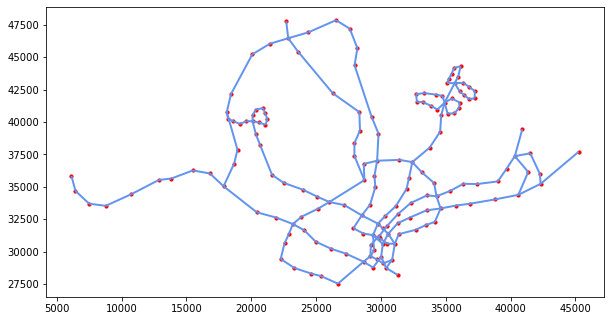

In [72]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = trn_route_shp.plot(lw=2, alpha=1, ax=ax1)
ax1 = trn_stn.plot(color='red', markersize=10, ax=ax1)

### 2.2.4. Construct Train Line (shapefile)

In [86]:
importlib.reload(gtn)

trn_lne_shp = gtn.TrainNet2LineShp(trn_mnet, trn_route)
# unify the CRS
trn_lne_shp = trn_lne_shp.set_crs(trn_stn.crs).to_crs(crs=UNION_CRS)

display(trn_lne_shp.head(5))

# # save file
# trn_lne_shp.to_file('GeoDatabase/shapefiles/train_line/train_line_20220127.shp')

,sublne_c,lne_c,lne_n,stn_seq,geometry
0,DT,05,Downtown Line,"00050,00159,00142,00141,00143,00011,00010,0007...","LINESTRING (42316.763 35232.432, 42262.245 359..."
1,EW,01,East-West Line,"00106,00141,00131,00145,00009,00074,00049,0010...","LINESTRING (40902.605 39439.871, 40327.325 373..."
2,CC,04,Circle Line,"00045,00019,00048,00113,00099,00137,00096,0004...","LINESTRING (29390.375 31278.814, 29929.447 310..."
3,NS,02,North-South Line,"00068,00023,00025,00035,00165,00079,00091,0016...","LINESTRING (17866.487 35045.184, 18676.448 367..."
4,NE,03,North East Line,"00059,00104,00033,00037,00045,00086,00053,0001...","LINESTRING (26685.636 27537.160, 28664.581 292..."


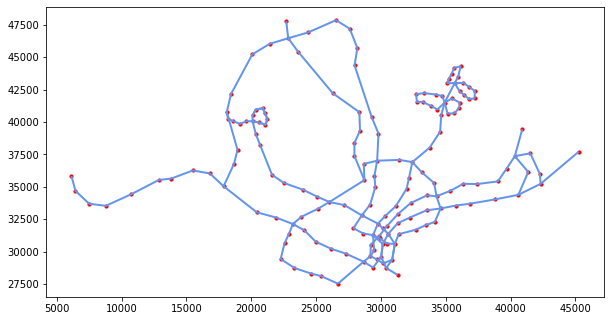

In [81]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = trn_lne_shp.plot(lw=2, alpha=1, ax=ax1)
ax1 = trn_stn.plot(color='red', markersize=10, ax=ax1)

### 2.2.5. Construct Node List and Edge List for *Gephi*

In [60]:
# print(list(trn_net.nodes[list(trn_net.nodes)[0]].keys()))
# print(list(trn_net.edges[list(trn_net.edges)[0]].keys()))
# print(trn_net.nodes[list(trn_net.nodes)[0]])
# print(trn_net.edges[list(trn_net.edges)[0]])

node_pd, edge_pd = gtn.TrainNet2NodeEges(trn_net)
display(node_pd.sort_values(by='sublne_num', ascending=False).head(5))
display(edge_pd.sort_values(by='lne_num', ascending=False).head(5))
print(node_pd.shape, edge_pd.shape)

# # save file
# path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Gephi - Train Nework')
# node_pd.to_csv(os.path.join(path, 'train_network_node_list_20220127.csv'), index=False)
# edge_pd.to_csv(os.path.join(path, 'train_network_edge_list_20220127.csv'), index=False)

,Id,stn_c,stn_n,lne_c,lne_n,lne_num,sublne_c,sublne_num,lng,lat
56,00045,"CC1,NE6,NS24",Dhoby Ghaut,"04,03,02","Circle Line,North East Line,North-South Line",3,"CC,NE,NS",3,29390.375,31278.814
0,00050,"CG1,DT35",Expo,"01,05","East-West Line,Downtown Line",2,"CG,DT",2,42316.763,35232.432
22,00027,"CC22,EW21",Buona Vista,"04,01","Circle Line,East-West Line",2,"CC,EW",2,23211.036,32132.716
37,00035,"BP1,NS4",Choa Chu Kang,"07,02","Bukit Panjang LRT Line,North-South Line",2,"BP,NS",2,18111.074,40771.636
41,00161,"NS9,TE2",Woodlands,"02,06","North-South Line,Thomson-East Coast Line",2,"NS,TE",2,22849.966,46461.232


,Source,Target,sublne_c,lne_c,lne_n,lne_num
21,00036,00117,"EW,NS","02,01","North-South Line,East-West Line",2
109,00113,00007,"DT,CE","04,05","Circle Line,Downtown Line",2
0,00050,00031,CG,01,East-West Line,1
118,00028,00017,CC,04,Circle Line,1
120,00017,00054,CC,04,Circle Line,1


(164, 10) (186, 6)


## 2.3. MRT Station Volume

In [ ]:
VOL_DATE = '202112'

path = os.path.join(ROOT_PATH, 'Public-Trainsit-Train', 'Volume', 
    'transport_node_train_{0}'.format(VOL_DATE[:4]),
    'transport_node_train_{0}.csv'.format(VOL_DATE)
)

trn_stn_vol = gtv.GetStopVol(path)
display(trn_stn_vol.head(5))
print(trn_stn_vol['BusStopCode'].unique().shape, trn_stn_vol.shape)

# 3. Zone information

## 3.1. Read Zone

In [62]:
path = os.path.join(ROOT_PATH, 'Zones',
    'master-plan-2019-subzone-boundary-no-sea', 
    'master-plan-2019-subzone-boundary-no-sea-kml.kml'
)

# transform the CRS of zone
zone = gzp.ReadZoneShp(path).to_crs(UNION_CRS)
# print(zone.columns)

zone1 = zone.dissolve(by='PLN_AREA_C', as_index=False, aggfunc='first')
# 'SUBZONE_C', 'PLN_AREA_C', 'REGION_C'

display(zone.head())
display(zone1.head())

zone.to_file('GeoDatabase/shapefiles/zone/zone_20220127.shp')

,SUBZONE_N,SUBZONE_C,PLN_AREA_N,PLN_AREA_C,REGION_N,REGION_C,geometry
0,MARINA EAST,MESZ01,MARINA EAST,ME,CENTRAL REGION,CR,"POLYGON Z ((33222.981 29588.127 0.000, 33222.5..."
1,INSTITUTION HILL,RVSZ05,RIVER VALLEY,RV,CENTRAL REGION,CR,"POLYGON Z ((28481.446 30886.220 0.000, 28483.4..."
2,ROBERTSON QUAY,SRSZ01,SINGAPORE RIVER,SR,CENTRAL REGION,CR,"POLYGON Z ((28087.344 30540.999 0.000, 28087.5..."
3,JURONG ISLAND AND BUKOM,WISZ01,WESTERN ISLANDS,WI,WEST REGION,WR,"MULTIPOLYGON Z (((14557.697 30447.212 0.000, 1..."
4,FORT CANNING,MUSZ02,MUSEUM,MU,CENTRAL REGION,CR,"POLYGON Z ((29542.526 31041.199 0.000, 29553.7..."


,PLN_AREA_C,geometry,SUBZONE_N,SUBZONE_C,PLN_AREA_N,REGION_N,REGION_C
0,AM,"POLYGON Z ((31070.935 39048.678 0.000, 31072.4...",CHONG BOON,AMSZ03,ANG MO KIO,NORTH-EAST REGION,NER
1,BD,"POLYGON Z ((38991.259 31986.560 0.000, 38992.5...",SIGLAP,BDSZ07,BEDOK,EAST REGION,ER
2,BK,"POLYGON Z ((20198.512 36532.010 0.000, 20205.8...",BRICKWORKS,BKSZ03,BUKIT BATOK,WEST REGION,WR
3,BL,"POLYGON Z ((12643.209 32171.068 0.000, 12643.0...",TUKANG,BLSZ01,BOON LAY,WEST REGION,WR
4,BM,"POLYGON Z ((26920.022 26969.570 0.000, 26920.0...",CITY TERMINALS,BMSZ17,BUKIT MERAH,CENTRAL REGION,CR


In [ ]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)
ax1 = zone.plot(alpha=0.3, edgecolor='black', linewidth=1, ax=ax1)
ax1 = zone.centroid.plot(color='green', markersize=2, ax=ax1)

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)
ax1 = zone1.plot(alpha=0.3, edgecolor='black', linewidth=1, ax=ax1)
ax1 = zone1.centroid.plot(color='green', markersize=2, ax=ax1)

## 3.2. Read Population

In [ ]:
path = os.path.join(ROOT_PATH, 'Populations',
    'singapore-residents-by-subzone-and-type-of-dwelling-2011-2019', 
    'planning-area-subzone-age-group-sex-and-type-of-dwelling-june-2011-2019.csv')
pop_raw = gzp.ReadZonePop(path)  

display(pop_raw.head())
# check SUBZONE_N and PLN_AREA_N column categorical values
# of pop_raw and zone whether are identical
gzp.CheckPopAndZoneMatch(pop_raw, zone)

pop = gzp.PopExtract(pop_raw, attrib='type_of_dwelling', zone_level='SUBZONE_N', year='2019')
pop1 = gzp.PopExtract(pop_raw, attrib='year', zone_level='PLN_AREA_N')
display(pop.head())
display(pop1.head())

## 3.3. Merge Zone and Population

In [ ]:
zone_pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
zone_pop1 = gzp.ZoneAddPop(zone1, pop1, zone_level='PLN_AREA_N')

display(zone_pop.head())
display(zone_pop1.head())

print(zone_pop.shape, zone_pop1.shape)


'''
# save file
pop = gzp.PopExtract(pop_raw, attrib='year', zone_level='SUBZONE_N')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_year.shp')

pop = gzp.PopExtract(pop_raw, attrib='type_of_dwelling', zone_level='SUBZONE_N', year='2019')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_type_2019.shp')

pop = gzp.PopExtract(pop_raw, attrib='sex', zone_level='SUBZONE_N', year='2019')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_sex_2019.shp')

pop = gzp.PopExtract(pop_raw, attrib='age_group', zone_level='SUBZONE_N', year='2019')
pop = gzp.ZoneAddPop(zone, pop, zone_level='SUBZONE_N')
pop.to_file('GeoDatabase/shapefiles/population/population_by_age_2019.shp')
'''

In [ ]:
data = zone_pop
col = 'total'

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax1 = data.plot(col, 
    alpha=0.3, edgecolor='black', linewidth=1, ax=ax1, 
    vmax=data[col].max(), vmin=data[col].min(),
    # cmap='cool', 
    legend=True, cax=cax
)